In [59]:
import pandas as pd                       
from datetime import datetime                     
import yfinance as yf                    
import seaborn as sns
import scipy.stats as st
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNet
from sklearn.svm import SVR            
                                          # Integrate algorithms
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pandas_datareader import data as pdr

In [67]:
### 設定想要的股票代碼資訊，以及要下載股價資訊的時間範圍
stock_name = 'AAPL'
start = datetime(2019, 1, 1)
end = datetime(2022, 11, 1)

### 下載股價資訊
df_full = pdr.get_data_yahoo(stock_name, start=start, end=end).reset_index()

df_full.to_csv(stock_name+'.csv',index=False)

### 看一下前幾筆資料長什麼樣子
df_full.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-12-31,39.840000,39.119999,39.632500,39.435001,140014000.0,38.061710
1,2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.105137
2,2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.309586
3,2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,35.774242
4,2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.694611


<AxesSubplot: title={'center': 'Adj Close'}, xlabel='Date'>

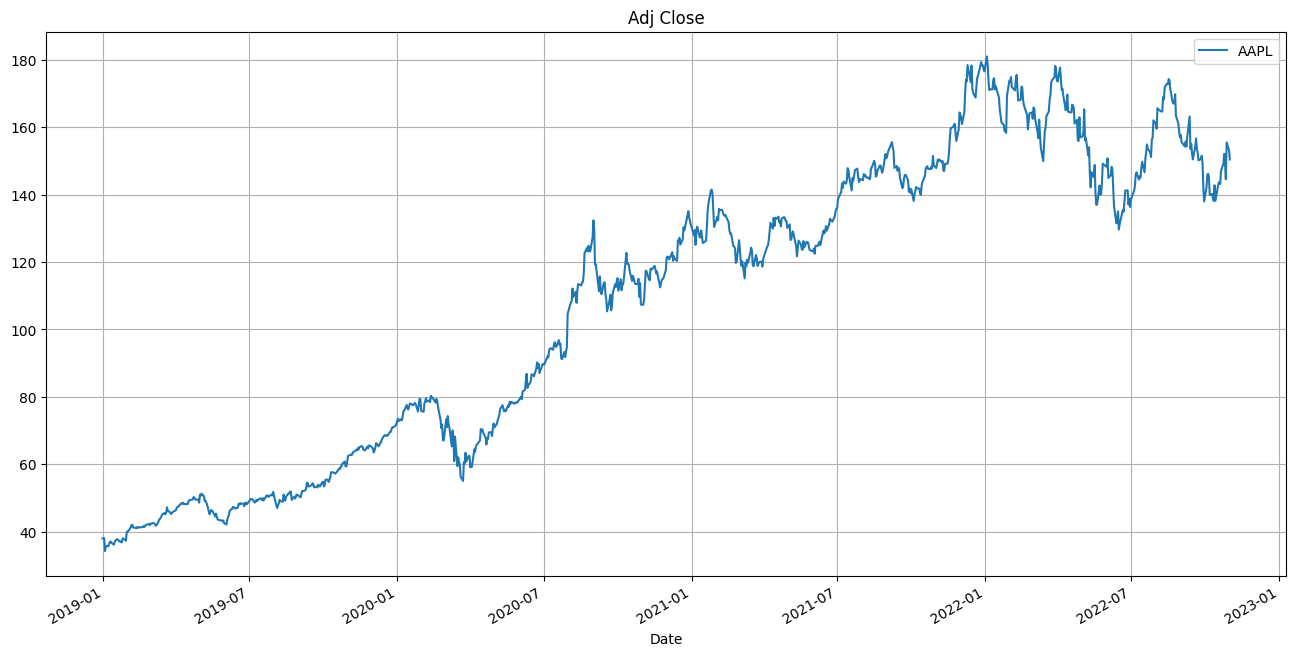

In [68]:
### 畫出股價資訊 2019/01/01~2020/06/14
df_full.set_index('Date', inplace=True)
df_raw = df_full[df_full.columns[-1]]
df_raw.plot(label=stock_name, figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)

<AxesSubplot: title={'center': 'Adj Close'}, xlabel='Date'>

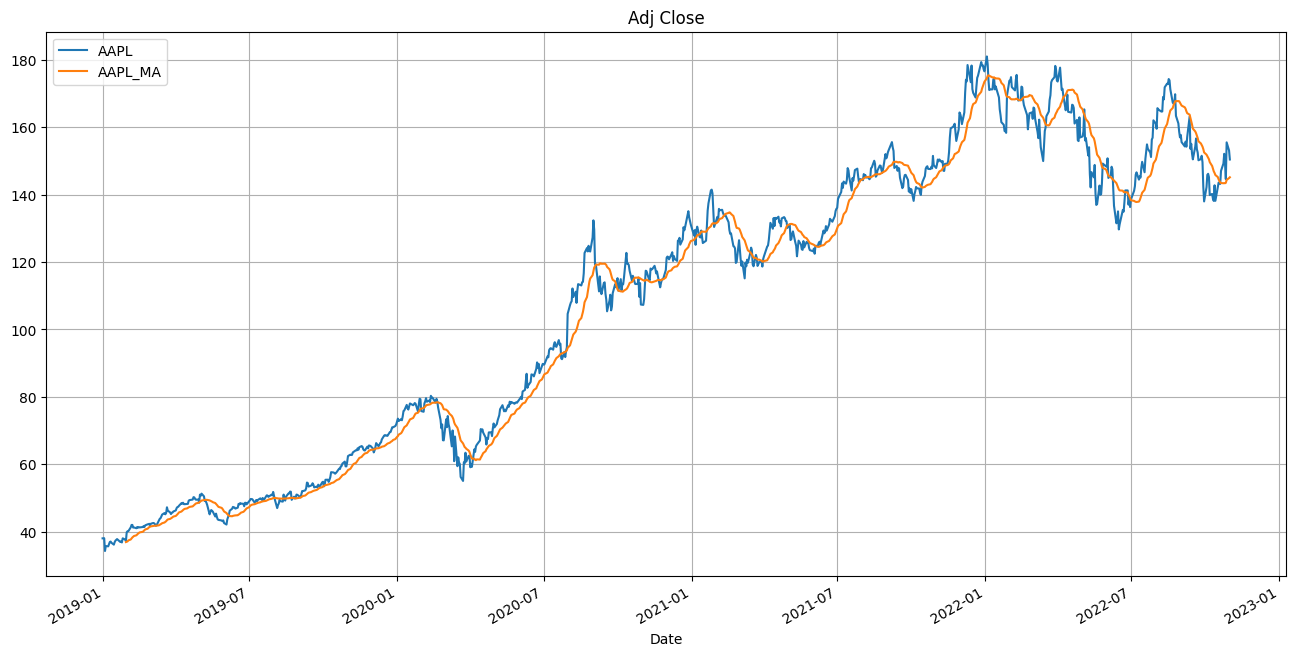

In [64]:
### 畫出移動平均線，每 20 天為一個移動單位
window = 20
df_MA = df_full[df_full.columns[-1]].rolling(window).mean()
df_raw.plot(label=stock_name, figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)
df_MA.plot(label=stock_name+'_MA', figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True)

In [71]:
### X 只拿第 1 天到第 N-1 天，而 y 則取第 2 天到第 N 天
df_X = df_full.iloc[:-1,:-1]
df_y = df_full.iloc[1:,-1]
print(df_X)
print(df_y)
X = df_X.to_numpy() 
y = df_y.to_numpy() 

### 訓練/測試的資料分割，以前 80% 的天數資料做訓練，後 20% 來做測試
num_data = df_X.shape[0]
split_ratio = 0.8
ind_split = int(split_ratio * num_data)

X_train = X[:ind_split]
y_train = y[:ind_split].reshape(-1,1)
X_test = X[ind_split:]
y_test = y[ind_split:].reshape(-1,1)

split_time = df_X.index[ind_split]

                  High         Low        Open       Close       Volume
Date                                                                   
2018-12-31   39.840000   39.119999   39.632500   39.435001  140014000.0
2019-01-02   39.712502   38.557499   38.722500   39.480000  148158800.0
2019-01-03   36.430000   35.500000   35.994999   35.547501  365248800.0
2019-01-04   37.137501   35.950001   36.132500   37.064999  234428400.0
2019-01-07   37.207500   36.474998   37.174999   36.982498  219111200.0
...                ...         ...         ...         ...          ...
2022-10-25  152.490005  149.360001  150.089996  152.339996   74732300.0
2022-10-26  151.990005  148.039993  150.960007  149.350006   88194300.0
2022-10-27  149.050003  144.130005  148.070007  144.800003  109180200.0
2022-10-28  157.500000  147.820007  148.199997  155.740005  164762400.0
2022-10-31  154.240005  151.919998  153.160004  153.339996   97943200.0

[967 rows x 5 columns]
Date
2019-01-02     38.105137
2019-01-03

In [70]:
# 建立線性迴歸模型
### 訓練模型
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

### 將訓練好的模型，用來做預測
trainings = reg_linear.predict(X_train).reshape(-1,1)
predictions = reg_linear.predict(X_test).reshape(-1,1)

### 將預測結果合在一起
all_pred = np.concatenate((trainings, predictions), axis=0)

### 計算方均根差
train_rmse = np.sqrt(1/X_train.shape[0]*np.squeeze(np.dot((trainings - y_train).T, (trainings - y_train))))
test_rmse = np.sqrt(1/X_test.shape[0]*np.squeeze(np.dot((predictions - y_test).T, (predictions - y_test))))

print("Training RMSE is: %f" % train_rmse)
print("Testing RMSE is: %f" % test_rmse)

Training RMSE is: 1.965153
Testing RMSE is: 3.537444


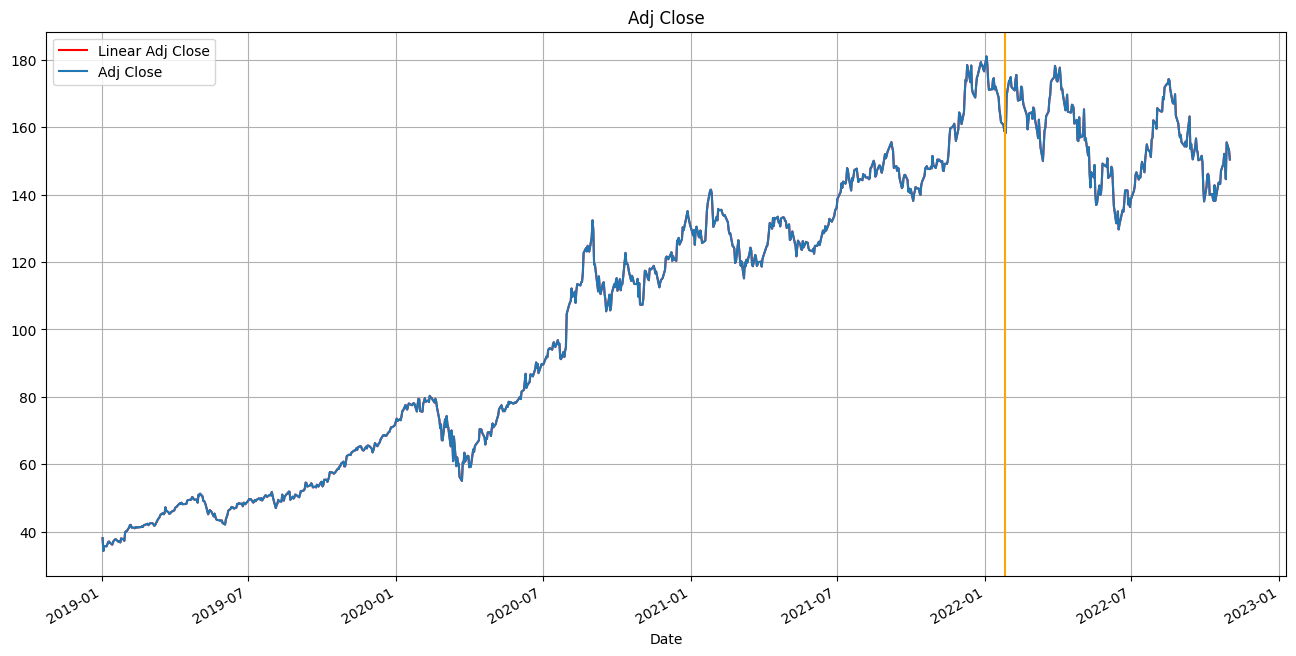

In [58]:
### 將預測和真實的股價，放進 df_linear 以便做圖
df_linear = pd.DataFrame(all_pred, columns=['Linear '+df_full.columns[-1]], index=df_y.index)
df_linear[df_full.columns[-1]] = y

### 畫出結果
df_linear.plot(figsize=(16,8), title=df_full.columns[-1], grid=True, legend=True, color=['r','C0'])
plt.axvline(pd.Timestamp(split_time),color='orange')